# Project 2: AGODA - RECOMMENDATION SYSTEM

## Thành viên

| STT | Họ và Tên       |
| --- | --------------- |
| 1   | Trần Đình Hùng  |
| 2   | Phạm Ngọc Trọng |

## Tổng quan thực hiện

|                 | Mô tả                                                                                                                                          |
| --------------- | ---------------------------------------------------------------------------------------------------------------------------------------------- |
| **Mục tiêu**    | 1. Triển khai hệ thống Recommender System giúp đề xuất khách sạn / resort phù hợp tới người dùng.<br>2. Cung cấp insight dựa trên thông tin khách hàng cho Chủ khách sạn. |
| **Data**        | Data_Agoda_raw/<br>`hotel_info.csv`<br>`hotel_comments.csv`<br><br>files/<br>`emojicon.txt`<br>`english-vnmese.txt`<br>`teencode.txt`<br>`vietnamese-stopwords.txt`<br>`vietnamese-stopwords.txt`|
| **Phương pháp** | `1. Content-based filtering with gensim + TF-IDF`<br>`2. Content-based filtering with cosine-similarity`<br>`3. Collaborative filtering with ALS (spark)`<br>4. Insight cho Chủ khách sạn|

## 1. Library


In [1]:
# !pip install gensim pyvi

In [2]:
import os
from datetime import datetime
import warnings
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import plotly.io as pio

# Data profiling (pandas-profiling)
from ydata_profiling import ProfileReport

# save model
import joblib # .pkl

# main library
from scipy.stats import skew
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

from gensim import corpora, models, similarities
from pyvi.ViTokenizer import tokenize

# spark
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import functions as F
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

## 2. Config

In [3]:
# path
path = "D:\\Data_science\\07_DoAn\\DL07_K306_PhamNgocTrong_TranDinhHung\\Project_2\\"
in_path = "data_input\\"
out_path = "data_output\\"
images_path = "images\\"
code_path = "source_code\\"
model_path = "models\\"

# variables
dash_len = 30
n_rows = 3
dpi = 150 # dot per inch
figsize = (10, 5) # inches
random_state = 42

# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# config seaborn
sns.set_style("whitegrid")
sns.set_palette("Set2")

# ignore alert message
warnings.filterwarnings("ignore")

## 2. Functions


In [4]:
# fn_show
def fn_show(
    df: pd.DataFrame, n: int = 3, truncate: bool = False, print_schema: bool = False
):
    if print_schema:
        print(df.info())
        print(f"{'-' * dash_len}\n")
    print(f"dataframe: {df.shape[0]:,} rows x {df.shape[1]:,} cols")
    display(df.head(n))

# fn_show_spark
def fn_show_spark(df, n: int = 3, printSchema: bool = False, truncate: bool = False):
    print(f"dataframe: {df.count():,} rows x {len(df.columns)} cols\n")
    if printSchema:
        df.printSchema()
    df.show(n, truncate=truncate)

In [5]:
# fn_file_listing
def fn_file_listing(root_path: str):
    if not os.path.exists(root_path):
        print(f"Path does not exist: {root_path}")
        return []
    file_list = []
    for dirpath, _, filenames in os.walk(root_path):
        # indent = ' ' * 4 * (dirpath.replace(root_path, '').count(os.sep))
        # print(f"{indent}{os.path.basename(dirpath)}/")
        for f in filenames:
            # print(f"{indent}    {f}")
            rel_path = os.path.relpath(os.path.join(dirpath, f), root_path)
            file_list.append(rel_path)
    return file_list

In [6]:
# fn_read_csv
def fn_read_csv(folder_path, file_name, header=True, sep=","):
    try:
        return pd.read_csv(os.path.join(folder_path, file_name), header=0 if header else None, sep=sep)
    except:
        return pd.DataFrame()

In [7]:
# fn_save_csv
def fn_save_csv(
    df: pd.DataFrame,
    folder_path: str,
    file_name: str,
    header: bool = True,
    index: bool = False,
    sep: str = ",",
    encoding: str = "utf-8",
):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    file_path = os.path.join(folder_path, file_name)
    try:
        df.to_csv(file_path, index=index, header=header, sep=sep, encoding=encoding)
        print(
            f"{os.path.basename(os.path.normpath(folder_path))}/\n"
            + "-" * dash_len
            + f"\n{file_name}"
        )
    except Exception as e:
        print(f"Error: {e}")

In [8]:
# # fn_column_listing
def fn_column_listing(df: pd.DataFrame) -> list:
    return list(df.columns)

In [9]:
# fn_rename
def fn_rename(df: pd.DataFrame) -> pd.DataFrame:
    import re, unicodedata
    def rm_accents(s): return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')
    df_temp = df.copy()
    df_temp.columns = [re.sub(r'\s+', '_', re.sub(r'[^a-z0-9\s]', ' ', rm_accents(str(c).lower()))).strip('_') for c in df.columns]
    return df_temp

In [10]:
# fn_Null_NaN_count
def fn_Null_NaN_count(df: pd.DataFrame) -> pd.DataFrame:
    results = []
    total_rows = len(df)
    for col in df.columns:
        null_cnt = df[col].isnull().sum()
        null_pct = round((null_cnt / total_rows) * 100, 1) if total_rows > 0 else 0.0
        nan_cnt = df[col].apply(lambda x: isinstance(x, float) and pd.isna(x)).sum()
        nan_pct = round((nan_cnt / total_rows) * 100, 1) if total_rows > 0 else 0.0
        results.append(
            {
                "column": col,
                "Null_cnt": null_cnt,
                "Null_pct": null_pct,
                "NaN_cnt": nan_cnt,
                "NaN_pct": nan_pct,
            }
        )
    display(pd.DataFrame(results))

In [11]:
# fn_date_format

# datetime pattern:
# -   "%d-%m-%Y":             day-month-year (ví dụ: 25-12-2023)
# -   "%d/%m/%Y %H:%M:%S":    day/month/year hour:minute:second (ví dụ: 25/12/2023 14:30:00)
# -   "%m-%d-%Y":             month-day-year (ví dụ: 12-25-2023)
# -   "%H:%M:%S":             hour:minute:second (ví dụ: 14:30:00)


def fn_date_format(
    df: pd.DataFrame,
    cols: list,
    date_pattern: str = "%Y-%m-%d",
) -> pd.DataFrame:
    df2 = df.copy()
    for col in cols:
        df2[col] = pd.to_datetime(df2[col], format=date_pattern, errors="raise")
    return df2

In [12]:
# fn_save_image
def fn_save_image(
    path: str, image_name: str, dpi: int, bbox_inches: str = "tight"
):
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)
    save_path = os.path.join(path, image_name)

    plt.savefig(save_path, dpi=dpi, bbox_inches=bbox_inches)
    print(
        f"{os.path.basename(os.path.normpath(path))}/\n"
        + "-" * dash_len
        + f"\n{image_name}"
    )

In [13]:
# fn_save_image_plotly
def fn_save_image_plotly(
    fig, path: str, image_name: str, figsize: tuple, scale: int = 1
):
    fig.write_image(f"{path}{image_name}", scale=scale, width=figsize[0], height=figsize[1])
    print(
        f"{os.path.basename(os.path.normpath(path))}/\n"
        + "-" * dash_len
        + f"\n{image_name}"
    )

In [14]:
# fn_chart_missingvalue_matrix
def fn_chart_missingvalue_matrix(df, title, figsize, color, dpi:int):
    import missingno as msno
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=figsize, dpi=dpi/2)
    msno.matrix(df, fontsize=10, sparkline=False, color=color, ax=ax)
    ax.set_title(title)
    plt.tight_layout()
    fn_save_image(path = path + images_path, image_name = title.replace(" ", "_"), dpi=dpi)
    plt.show()

In [15]:
# fn_chart_corr
def fn_chart_corr(df, figsize, dpi, title="Correlation Heatmap", cols=None):
    d = df[cols] if cols else df.select_dtypes("number")
    c = d.corr()
    plt.figure(figsize=figsize, dpi=dpi)
    mask = np.triu(np.ones_like(c, dtype=bool), k=1)
    ax = sns.heatmap(
        c,
        mask=mask,
        annot=True,
        fmt=".2f",
        cmap="RdBu",
        vmin=-1,
        vmax=1,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
        square=True,
        annot_kws={"size": 6},
    )
    plt.title(title, fontsize=12, fontweight="bold")
    plt.xticks(rotation=90, ha="right")
    plt.yticks(rotation=0)
    plt.grid(False)
    plt.tight_layout()
    fn_save_image(path=path + images_path, image_name=title.replace(" ", "_"), dpi=dpi)
    plt.show()

In [16]:
# fn_save_model_joblib
def fn_save_model_joblib(model, folder_path:str, model_name:str):
    os.makedirs(folder_path, exist_ok=True)
    joblib.dump(model, os.path.join(folder_path, model_name), compress=3, protocol=4)
    print(
    f"{os.path.basename(os.path.normpath(folder_path))}/\n"
    + "-" * dash_len
    + f"\n{model_name}"
)

In [17]:
# fn_load_model_joblib
def fn_load_model_joblib(folder_path: str, model_name: str):
    # import os, joblib
    path = os.path.join(folder_path, model_name)
    # if not os.path.exists(path):
    #     raise FileNotFoundError(f"Model not found: {path}")
    return joblib.load(path)

In [18]:
def fn_gensim_save_sparsematrixsimilarity(
    index_matrix, folder_path: str, file_name: str
):
    file_path = folder_path + file_name
    index_matrix.save(file_path)
    print(
        f"{os.path.basename(os.path.normpath(folder_path))}/\n"
        + "-" * dash_len
        + f"\n{file_name}"
    )


def fn_gensim_load_sparsematrixsimilarity(folder_path: str, file_name: str):
    from gensim.similarities import SparseMatrixSimilarity

    file_path = folder_path + file_name
    index_matrix = SparseMatrixSimilarity.load(file_path)
    # print(f"SparseMatrixSimilarity object loaded from: {file_path}")
    return index_matrix

In [19]:
# save matrix
def fn_cosine_sim_save(cosine_sim, folder_path, file_name):
    # os.makedirs(folder_path, exist_ok=True)
    file_path = os.path.join(folder_path, file_name)
    np.save(file_path, cosine_sim)
    print(
        f"{os.path.basename(os.path.normpath(folder_path))}/\n"
        + "-" * dash_len
        + f"\n{file_name}"
    )

# load matrix
def fn_cosine_sim_load(folder_path, file_name):
    file_path = os.path.join(folder_path, file_name)
    return np.load(file_path)

In [20]:
# fn_extract_nums
def fn_extract_nums(s: str) -> list:
    import re
    nums = re.findall(r"\d+(?:[.,]\d+)*", s)
    res = []
    for n in nums:
        try:
            if "," in n and "." in n:
                res.append(float(n.replace(",", "")))
            elif "," in n:
                res.append(int(n.replace(",", "")))
            elif "." in n:
                res.append(float(n))
            else:
                res.append(int(n))
        except: continue
    return res

In [21]:
# fn_date()
# convert [30, 7, 2023] to '2023-07-30'
def fn_date(lst):
    import datetime
    try:
        return datetime.datetime(int(lst[2]), int(lst[1]), int(lst[0]))
    except:
        return None

In [22]:
# fn_astype_float
def fn_astype_float(df: pd.DataFrame, col:str) -> pd.DataFrame:
    df_temp = df.copy()
    df_temp[col] = df_temp[col].astype(str).str.replace(',', '.', regex=False).replace('nan', np.nan).astype(float)
    return df_temp

In [23]:
# fn_read_dict
def fn_read_dict(path):
    d = {}
    with open(path, 'r', encoding='utf-8') as f:
        for i, line in enumerate(f, 1):
            if '\t' in line:
                eng, vie = line.strip().split('\t', 1)
                d[eng.strip()] = vie.strip()
    return d

In [24]:
# fn_read_txt
def fn_read_txt(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [line.rstrip('\n') for line in f]

In [25]:
def fn_clean_word(
    text,
    remove_number=True,
    remove_punctuation=True,
    remove_vie_tone=False,
    lower=False,
):
    import re, unicodedata
    if not isinstance(text, str):
        if text is None or (isinstance(text, float) and np.isnan(text)):
            return ""
        text = str(text)
    if lower:
        text = text.lower()
    if remove_vie_tone:
        text = unicodedata.normalize('NFD', text)
        text = ''.join(ch for ch in text if unicodedata.category(ch) != 'Mn')
    if remove_punctuation:
        text = ''.join(ch for ch in text if not (unicodedata.category(ch).startswith('P') and ch != ' '))
    if remove_number:
        text = re.sub(r'\d+', '', text)
    return text.strip()

def fn_clean_tokens(
    tokens,
    dict_list=None,
    stopword=None,
    wrongword=None,
):
    def _normalize_token(tok):
        if dict_list:
            for d in dict_list:
                if tok in d:
                    tok = d[tok]
        return tok

    def _clean_one(tok_list):
        cleaned = []
        for tok in tok_list:
            tok = _normalize_token(tok)
            if stopword and tok in stopword:
                continue
            if wrongword and tok in wrongword:
                continue
            if tok.strip():
                cleaned.append(tok)
        return cleaned

    if isinstance(tokens[0], list):
        return [_clean_one(tok_list) for tok_list in tokens]
    else:
        return _clean_one(tokens)


## 3. Read input data


In [26]:
# check input folder
print(f"{in_path}\n" + "-" * dash_len)
for f in fn_file_listing(path + in_path):
    print(f)

data_input\
------------------------------
Data_Agoda_raw\hotel_comments.csv
Data_Agoda_raw\hotel_info.csv
Data_Agoda_raw\readme_v2.docx
files\emojicon.txt
files\english-vnmese.txt
files\teencode.txt
files\vietnamese-stopwords.txt
files\wrong-word.txt


In [27]:
# read raw data
df_hotel_comments_raw = fn_read_csv(folder_path=path + in_path, file_name="Data_Agoda_raw\hotel_comments.csv", header=True, sep=",")
df_hotel_info_raw = fn_read_csv(folder_path=path + in_path, file_name="Data_Agoda_raw\hotel_info.csv", header=True, sep=",")

In [28]:
fn_show(df=df_hotel_comments_raw, n=n_rows, print_schema=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80314 entries, 0 to 80313
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   num            80314 non-null  int64 
 1   Hotel ID       80314 non-null  object
 2   Reviewer ID    80314 non-null  object
 3   Reviewer Name  80228 non-null  object
 4   Nationality    80314 non-null  object
 5   Group Name     80314 non-null  object
 6   Room Type      80314 non-null  object
 7   Stay Details   80314 non-null  object
 8   Score          80314 non-null  object
 9   Score Level    80314 non-null  object
 10  Title          80314 non-null  object
 11  Body           80272 non-null  object
 12  Review Date    80314 non-null  object
dtypes: int64(1), object(12)
memory usage: 8.0+ MB
None
------------------------------

dataframe: 80,314 rows x 13 cols


,num,Hotel ID,Reviewer ID,Reviewer Name,Nationality,Group Name,Room Type,Stay Details,Score,Score Level,Title,Body,Review Date
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,"10,0",Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,Đã nhận xét vào 30 tháng 7 2023
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 1 đêm vào Tháng 9 năm 2022,"10,0",Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,Đã nhận xét vào 05 tháng 9 2022
2,3,1_1,1_1_3,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,Đã ở 1 đêm vào Tháng 6 năm 2024,"9,2",Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",Đã nhận xét vào 25 tháng 6 2024


In [29]:
fn_show(df=df_hotel_info_raw, n=n_rows, print_schema=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   num                       740 non-null    int64 
 1   Hotel_ID                  740 non-null    object
 2   Hotel_Name                740 non-null    object
 3   Hotel_Rank                740 non-null    object
 4   Hotel_Address             740 non-null    object
 5   Total_Score               740 non-null    object
 6   Location                  413 non-null    object
 7   Cleanliness               412 non-null    object
 8   Service                   373 non-null    object
 9   Facilities                370 non-null    object
 10  Value_for_money           410 non-null    object
 11  Comfort_and_room_quality  51 non-null     object
 12  comments_count            740 non-null    int64 
 13  Hotel_Description         739 non-null    object
dtypes: int64(2), object(12)
me

,num,Hotel_ID,Hotel_Name,Hotel_Rank,Hotel_Address,Total_Score,Location,Cleanliness,Service,Facilities,Value_for_money,Comfort_and_room_quality,comments_count,Hotel_Description
0,1,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5 sao trên 5,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,8","9,4","8,9","8,9","8,7","8,7","8,3",1269,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...
1,2,1_2,ALPHA BIRD NHA TRANG,4 sao trên 5,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...","7,7","7,8","7,6","8,1","7,5","8,1",NaN,337,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...
2,3,1_3,Khách sạn Aaron (Aaron Hotel),3.5 sao trên 5,"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...","8,5","8,9","8,7","8,8","8,1","8,5",NaN,300,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...


## 4. EDA


### 4.1 Renamed Cols


In [30]:
df_hotel_info_raw = fn_rename(df=df_hotel_info_raw)
df_hotel_comments_raw = fn_rename(df=df_hotel_comments_raw)

fn_show(df=df_hotel_info_raw, n=n_rows)
fn_show(df=df_hotel_comments_raw, n=n_rows)

dataframe: 740 rows x 14 cols


,num,hotel_id,hotel_name,hotel_rank,hotel_address,total_score,location,cleanliness,service,facilities,value_for_money,comfort_and_room_quality,comments_count,hotel_description
0,1,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,5 sao trên 5,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,8","9,4","8,9","8,9","8,7","8,7","8,3",1269,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...
1,2,1_2,ALPHA BIRD NHA TRANG,4 sao trên 5,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...","7,7","7,8","7,6","8,1","7,5","8,1",NaN,337,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...
2,3,1_3,Khách sạn Aaron (Aaron Hotel),3.5 sao trên 5,"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...","8,5","8,9","8,7","8,8","8,1","8,5",NaN,300,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...


dataframe: 80,314 rows x 13 cols


,num,hotel_id,reviewer_id,reviewer_name,nationality,group_name,room_type,stay_details,score,score_level,title,body,review_date
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 3 đêm vào Tháng 7 năm 2023,"10,0",Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,Đã nhận xét vào 30 tháng 7 2023
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,Đã ở 1 đêm vào Tháng 9 năm 2022,"10,0",Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,Đã nhận xét vào 05 tháng 9 2022
2,3,1_1,1_1_3,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,Đã ở 1 đêm vào Tháng 6 năm 2024,"9,2",Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",Đã nhận xét vào 25 tháng 6 2024


### 4.2 Extract info

In [31]:
# extract review date
df_hotel_comments_raw['review_date_2'] = df_hotel_comments_raw['review_date'].apply(fn_extract_nums).apply(fn_date)
# extract stay_details : stay_month & stay_nights
df_hotel_comments_raw['stay_nights'] = df_hotel_comments_raw['stay_details'].apply(lambda x: fn_extract_nums(x)[0]).astype(int)
df_hotel_comments_raw['stay_month'] = df_hotel_comments_raw['stay_details'].apply(lambda x: [1] + fn_extract_nums(x)[1:3]).apply(fn_date)

# drop stay_details, review_date cols
df_hotel_comments = df_hotel_comments_raw.drop(columns=['stay_details', 'review_date']).rename(columns={'review_date_2': 'review_date'})

fn_show(df=df_hotel_comments, n=n_rows)

dataframe: 80,314 rows x 14 cols


,num,hotel_id,reviewer_id,reviewer_name,nationality,group_name,room_type,score,score_level,title,body,review_date,stay_nights,stay_month
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,"10,0",Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,2023-07-30,3,2023-07-01
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,"10,0",Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,2022-09-05,1,2022-09-01
2,3,1_1,1_1_3,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,"9,2",Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",2024-06-25,1,2024-06-01


In [32]:
# extract hotel_rank
df_hotel_info_raw['hotel_rank_2'] = df_hotel_info_raw['hotel_rank'].apply(
    lambda x: fn_extract_nums(x)[0] if fn_extract_nums(x) and len(fn_extract_nums(x)) > 0 else np.nan
)

# drop hotel_rank col
df_hotel_info = df_hotel_info_raw.drop(columns=['hotel_rank']).rename(columns={'hotel_rank_2': 'hotel_rank'})
fn_show(df=df_hotel_info, n=n_rows)

dataframe: 740 rows x 14 cols


,num,hotel_id,hotel_name,hotel_address,total_score,location,cleanliness,service,facilities,value_for_money,comfort_and_room_quality,comments_count,hotel_description,hotel_rank
0,1,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam","8,8","9,4","8,9","8,9","8,7","8,7","8,3",1269,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,5.0
1,2,1_2,ALPHA BIRD NHA TRANG,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...","7,7","7,8","7,6","8,1","7,5","8,1",NaN,337,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...,4.0
2,3,1_3,Khách sạn Aaron (Aaron Hotel),"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...","8,5","8,9","8,7","8,8","8,1","8,5",NaN,300,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...,3.5


### 4.3 Replace values

In [33]:
# những cột cần kiểm tra "No infomartion" xuất hiện ở các cột score
lst_info_score = ['total_score', 'location', 'cleanliness', 'service', 'facilities', 'value_for_money', 'comfort_and_room_quality', 'hotel_rank']
lst_comments_score = ['score']

In [34]:
# check "No information" xuất hiện ở các cột score
for c in lst_info_score:
    print(f"{c}:\n{sorted(df_hotel_info[c].astype(str).unique(), reverse=True)}\n")

# check No information" xuất hiện ở các cột score
for c in lst_comments_score:
    print(f"{c}:\n{sorted(df_hotel_comments[c].astype(str).unique(), reverse=True)}\n")

total_score:
['No information', '9,9', '9,8', '9,7', '9,6', '9,5', '9,4', '9,3', '9,2', '9,1', '9,0', '8,9', '8,8', '8,7', '8,6', '8,5', '8,4', '8,3', '8,2', '8,1', '8,0', '7,9', '7,8', '7,7', '7,6', '7,5', '7,4', '7,3', '7,2', '7,1', '7,0', '6,9', '6,8', '6,7', '6,6', '6,5', '6,4', '6,3', '6,2', '6,1', '5,8', '5,6', '5,3', '5,2', '5,0', '4,8', '4,4', '4,3', '3,5', '2,8', '2,6', '2,5', '2,0', '10']

location:
['nan', '9,7', '9,6', '9,5', '9,4', '9,3', '9,2', '9,1', '9,0', '8,9', '8,8', '8,7', '8,6', '8,5', '8,4', '8,3', '8,2', '8,1', '8,0', '7,9', '7,8', '7,7', '7,6', '7,5', '7,4', '7,3', '7,2', '7,1', '6,8', '6,7', '6,6', '6,5', '6,4', '6,0', '5,5', '5,3', '5,2', '5,0', '4,7', '4,0', '3,0', '2,0', '10,0']

cleanliness:
['nan', '9,9', '9,8', '9,7', '9,6', '9,5', '9,4', '9,3', '9,2', '9,1', '9,0', '8,9', '8,8', '8,7', '8,6', '8,5', '8,4', '8,3', '8,2', '8,1', '8,0', '7,9', '7,8', '7,7', '7,6', '7,5', '7,4', '7,3', '7,2', '7,1', '7,0', '6,9', '6,8', '6,7', '6,6', '6,5', '6,4', '6,0', '5,

In [35]:
# replace "No information" bằng NaN nếu có
for c in lst_info_score:
    df_hotel_info[c] = df_hotel_info[c].replace('No information', np.nan)

for c in lst_comments_score:
    df_hotel_comments[c] = df_hotel_comments[c].replace('No information', np.nan)    

# after replace
for c in lst_info_score:
    print(f"{c}:\n{sorted(df_hotel_info[c].astype(str).unique(), reverse=True)}\n")

for c in lst_comments_score:
    print(f"{c}:\n{sorted(df_hotel_comments[c].astype(str).unique(), reverse=True)}\n")

total_score:
['nan', '9,9', '9,8', '9,7', '9,6', '9,5', '9,4', '9,3', '9,2', '9,1', '9,0', '8,9', '8,8', '8,7', '8,6', '8,5', '8,4', '8,3', '8,2', '8,1', '8,0', '7,9', '7,8', '7,7', '7,6', '7,5', '7,4', '7,3', '7,2', '7,1', '7,0', '6,9', '6,8', '6,7', '6,6', '6,5', '6,4', '6,3', '6,2', '6,1', '5,8', '5,6', '5,3', '5,2', '5,0', '4,8', '4,4', '4,3', '3,5', '2,8', '2,6', '2,5', '2,0', '10']

location:
['nan', '9,7', '9,6', '9,5', '9,4', '9,3', '9,2', '9,1', '9,0', '8,9', '8,8', '8,7', '8,6', '8,5', '8,4', '8,3', '8,2', '8,1', '8,0', '7,9', '7,8', '7,7', '7,6', '7,5', '7,4', '7,3', '7,2', '7,1', '6,8', '6,7', '6,6', '6,5', '6,4', '6,0', '5,5', '5,3', '5,2', '5,0', '4,7', '4,0', '3,0', '2,0', '10,0']

cleanliness:
['nan', '9,9', '9,8', '9,7', '9,6', '9,5', '9,4', '9,3', '9,2', '9,1', '9,0', '8,9', '8,8', '8,7', '8,6', '8,5', '8,4', '8,3', '8,2', '8,1', '8,0', '7,9', '7,8', '7,7', '7,6', '7,5', '7,4', '7,3', '7,2', '7,1', '7,0', '6,9', '6,8', '6,7', '6,6', '6,5', '6,4', '6,0', '5,9', '5,8', 

In [36]:
#  cột hotel_description có lỗi #NAME?
df_hotel_info['hotel_description'] = df_hotel_info['hotel_description'].replace('#NAME?', np.nan)

In [37]:
# remove các dấu xuống dòng
for col in df_hotel_info.select_dtypes(include=['object']).columns:
    df_hotel_info[col] = df_hotel_info[col].apply(lambda x: str(x).replace('\n', ' ').strip() if pd.notnull(x) else x)

for col in df_hotel_comments.select_dtypes(include=['object']).columns:
    df_hotel_comments[col] = df_hotel_comments[col].apply(lambda x: str(x).replace('\n', ' ').strip() if pd.notnull(x) else x)    

### 4.4 Astype

In [38]:
# Đổi kiểu dữ liệu các cột score về float
for c in lst_info_score:
    df_hotel_info = fn_astype_float(df=df_hotel_info, col=c)

for c in lst_comments_score:
    df_hotel_comments = fn_astype_float(df=df_hotel_comments, col=c)    

In [39]:
# data sau chuyển kiểu dữ liệu
fn_show(df=df_hotel_info, n=n_rows, print_schema=True)
fn_show(df=df_hotel_comments, n=n_rows, print_schema=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 740 entries, 0 to 739
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   num                       740 non-null    int64  
 1   hotel_id                  740 non-null    object 
 2   hotel_name                740 non-null    object 
 3   hotel_address             740 non-null    object 
 4   total_score               414 non-null    float64
 5   location                  413 non-null    float64
 6   cleanliness               412 non-null    float64
 7   service                   373 non-null    float64
 8   facilities                370 non-null    float64
 9   value_for_money           410 non-null    float64
 10  comfort_and_room_quality  51 non-null     float64
 11  comments_count            740 non-null    int64  
 12  hotel_description         735 non-null    object 
 13  hotel_rank                267 non-null    float64
dtypes: float64

,num,hotel_id,hotel_name,hotel_address,total_score,location,cleanliness,service,facilities,value_for_money,comfort_and_room_quality,comments_count,hotel_description,hotel_rank
0,1,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",8.8,9.4,8.9,8.9,8.7,8.7,8.3,1269,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,5.0
1,2,1_2,ALPHA BIRD NHA TRANG,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...",7.7,7.8,7.6,8.1,7.5,8.1,NaN,337,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...,4.0
2,3,1_3,Khách sạn Aaron (Aaron Hotel),"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...",8.5,8.9,8.7,8.8,8.1,8.5,NaN,300,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...,3.5


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80314 entries, 0 to 80313
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   num            80314 non-null  int64         
 1   hotel_id       80314 non-null  object        
 2   reviewer_id    80314 non-null  object        
 3   reviewer_name  80228 non-null  object        
 4   nationality    80314 non-null  object        
 5   group_name     80314 non-null  object        
 6   room_type      80314 non-null  object        
 7   score          80314 non-null  float64       
 8   score_level    80314 non-null  object        
 9   title          80314 non-null  object        
 10  body           80272 non-null  object        
 11  review_date    80314 non-null  datetime64[ns]
 12  stay_nights    80314 non-null  int32         
 13  stay_month     80314 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int32(1), int64(1), object(9)
memory

,num,hotel_id,reviewer_id,reviewer_name,nationality,group_name,room_type,score,score_level,title,body,review_date,stay_nights,stay_month
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,10.0,Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,2023-07-30,3,2023-07-01
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,10.0,Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,2022-09-05,1,2022-09-01
2,3,1_1,1_1_3,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,9.2,Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",2024-06-25,1,2024-06-01


### 4.5 Data profiling

In [40]:
# extract hotel_rank
ProfileReport(
    df_hotel_info,
    title="df_hotel_info Data Profiling Report",
    explorative=True,
).to_file(path + out_path + "df_hotel_info_profile.html")

ProfileReport(
    df_hotel_comments,
    title="df_hotel_comments Data Profiling Report",
    explorative=True,
).to_file(path + out_path + "df_hotel_comments_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 19.00it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:02<00:00,  4.90it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [41]:
# List profile ".html"
print(f"{out_path}\n" + "-" * dash_len)
for f in fn_file_listing(root_path=path + out_path):
    if f.endswith('.html'):
        print(f)

data_output\
------------------------------
df_hotel_comments_profile.html
df_hotel_info_profile.html


### 4.6 Data description


#### Hotel info

In [42]:
# Data description: info
fn_show(df=df_hotel_info.describe().T, n=None)
fn_show(df=df_hotel_info.describe(include="object").T, n=None)

dataframe: 10 rows x 8 cols


,count,mean,std,min,25%,50%,75%,max
num,740.0,370.500000,213.763888,1.0,185.750,370.50,555.25,740.0
total_score,414.0,8.014734,1.763279,2.0,7.700,8.50,8.90,10.0
location,413.0,8.273123,1.923609,2.0,8.200,8.70,9.30,10.0
cleanliness,412.0,8.121845,1.914246,2.0,7.800,8.70,9.20,10.0
service,373.0,8.295442,1.741000,2.0,8.000,8.80,9.20,10.0
facilities,370.0,7.903514,1.697763,2.0,7.425,8.25,8.90,10.0
value_for_money,410.0,8.182439,1.889938,2.0,8.000,8.70,9.20,10.0
comfort_and_room_quality,51.0,8.301961,1.207227,3.0,7.700,8.50,9.10,10.0
comments_count,740.0,94.401351,258.096718,0.0,0.000,0.00,28.25,1464.0
hotel_rank,267.0,4.134831,0.993676,1.0,3.500,4.50,5.00,5.0


dataframe: 4 rows x 4 cols


,count,unique,top,freq
hotel_id,740,740,1_1,1
hotel_name,740,740,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,1
hotel_address,740,361,"Lộc Thọ, Nha Trang, Việt Nam",114
hotel_description,735,701,Cho dù làm việc từ xa hay du lịch cùng gia đìn...,6


,column,Null_cnt,Null_pct,NaN_cnt,NaN_pct
0,num,0,0.0,0,0.0
1,hotel_id,0,0.0,0,0.0
2,hotel_name,0,0.0,0,0.0
3,hotel_address,0,0.0,0,0.0
4,total_score,326,44.1,326,44.1
5,location,327,44.2,327,44.2
6,cleanliness,328,44.3,328,44.3
7,service,367,49.6,367,49.6
8,facilities,370,50.0,370,50.0
9,value_for_money,330,44.6,330,44.6


images/
------------------------------
01_df_hotel_info_MISSING_VALUES_MATRIX


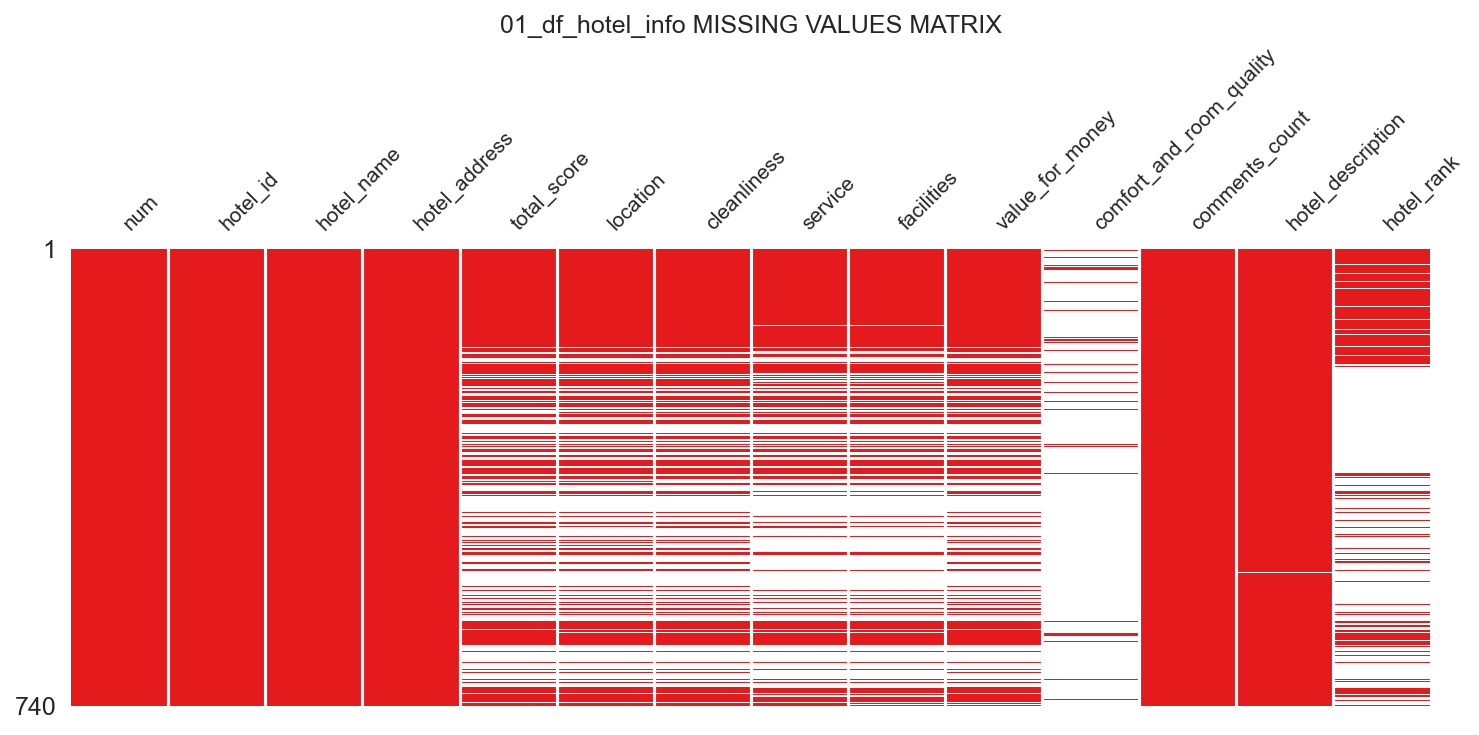

In [43]:
# check Null/NaN
fn_Null_NaN_count(df=df_hotel_info)
fn_chart_missingvalue_matrix(df=df_hotel_info, title="01_df_hotel_info MISSING VALUES MATRIX", figsize=figsize, color=sns.color_palette("Set1")[0], dpi=dpi)

images/
------------------------------
03_df_hotel_info_correlation_heatmap


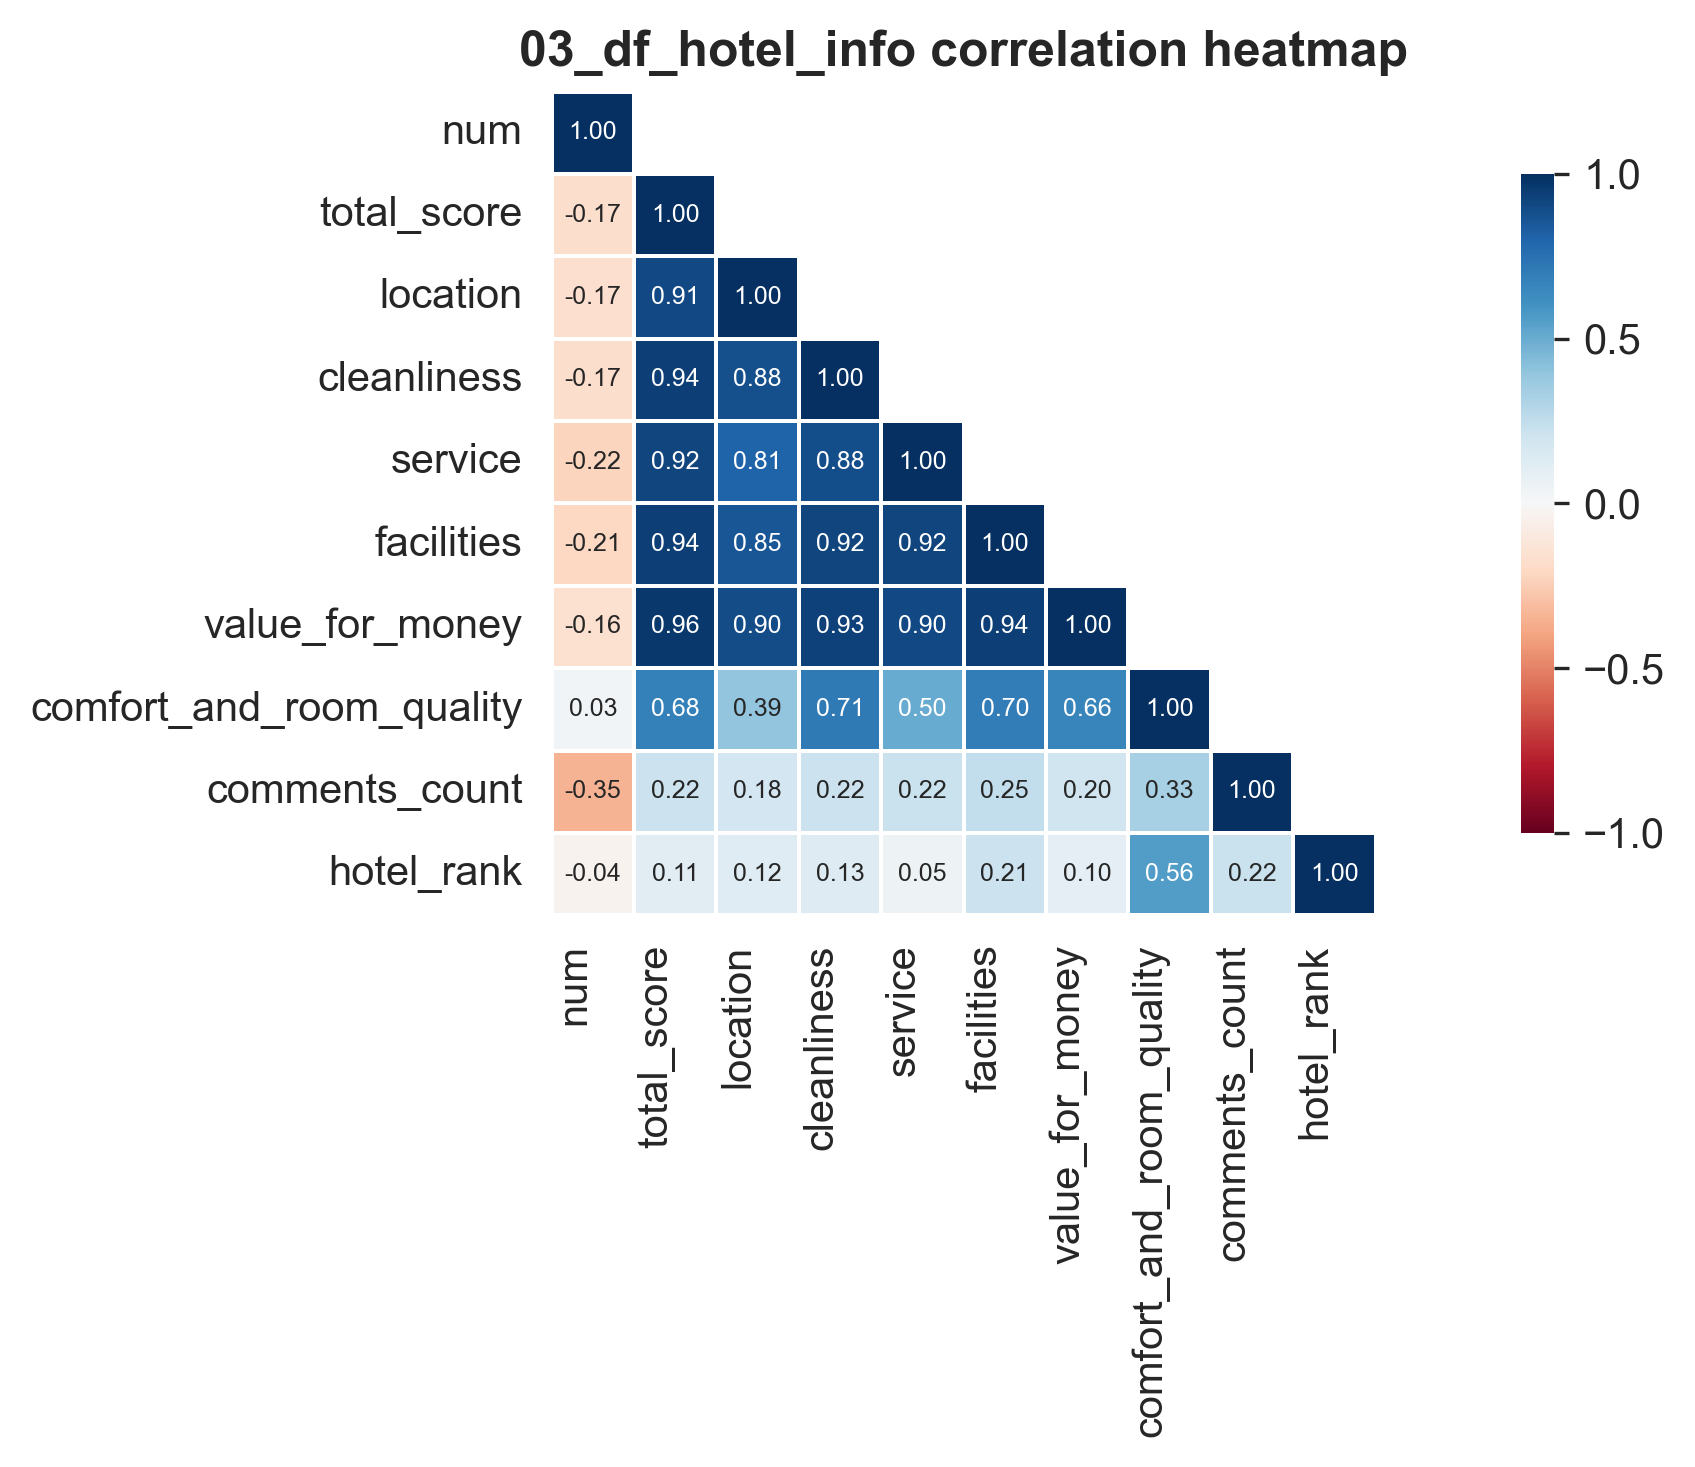

In [44]:
# corr heatmap
fn_chart_corr(df=df_hotel_info, cols=list(df_hotel_info.select_dtypes("number")), figsize=figsize, dpi=dpi, title='03_df_hotel_info correlation heatmap')

#### Hotel comments

In [45]:
# Data description: comments
fn_show(df=df_hotel_comments.describe().T, n=None)
fn_show(df=df_hotel_comments.describe(include="object").T, n=None)

dataframe: 5 rows x 8 cols


,count,mean,min,25%,50%,75%,max,std
num,80314.0,40157.5,1.0,20079.25,40157.5,60235.75,80314.0,23184.799097
score,80314.0,9.30992,6.3,8.8,9.6,10.0,10.0,0.946278
review_date,80314,2022-11-09 00:34:58.842044928,2009-11-15 00:00:00,2022-07-26 00:00:00,2023-08-25 00:00:00,2024-03-19 00:00:00,2024-07-17 00:00:00,NaN
stay_nights,80314.0,2.068842,1.0,1.0,2.0,3.0,41.0,1.568909
stay_month,80314,2022-10-01 01:49:26.546305792,2009-11-01 00:00:00,2022-07-01 00:00:00,2023-08-01 00:00:00,2024-02-01 00:00:00,2024-07-01 00:00:00,NaN


dataframe: 9 rows x 4 cols


,count,unique,top,freq
hotel_id,80314,473,10_12,1464
reviewer_id,80314,80314,1_1_1,1
reviewer_name,80228,8190,Nguyễn,1612
nationality,80314,110,Việt Nam,49433
group_name,80314,6,Cặp đôi,31068
room_type,80314,1331,Deluxe giường đôi Hướng phố,2054
score_level,80314,4,Trên cả tuyệt vời,58051
title,80314,14410,Trên cả tuyệt vời”,15494
body,80272,24899,Good,775


,column,Null_cnt,Null_pct,NaN_cnt,NaN_pct
0,num,0,0.0,0,0.0
1,hotel_id,0,0.0,0,0.0
2,reviewer_id,0,0.0,0,0.0
3,reviewer_name,86,0.1,86,0.1
4,nationality,0,0.0,0,0.0
5,group_name,0,0.0,0,0.0
6,room_type,0,0.0,0,0.0
7,score,0,0.0,0,0.0
8,score_level,0,0.0,0,0.0
9,title,0,0.0,0,0.0


images/
------------------------------
02_df_hotel_comments_MISSING_VALUES_MATRIX


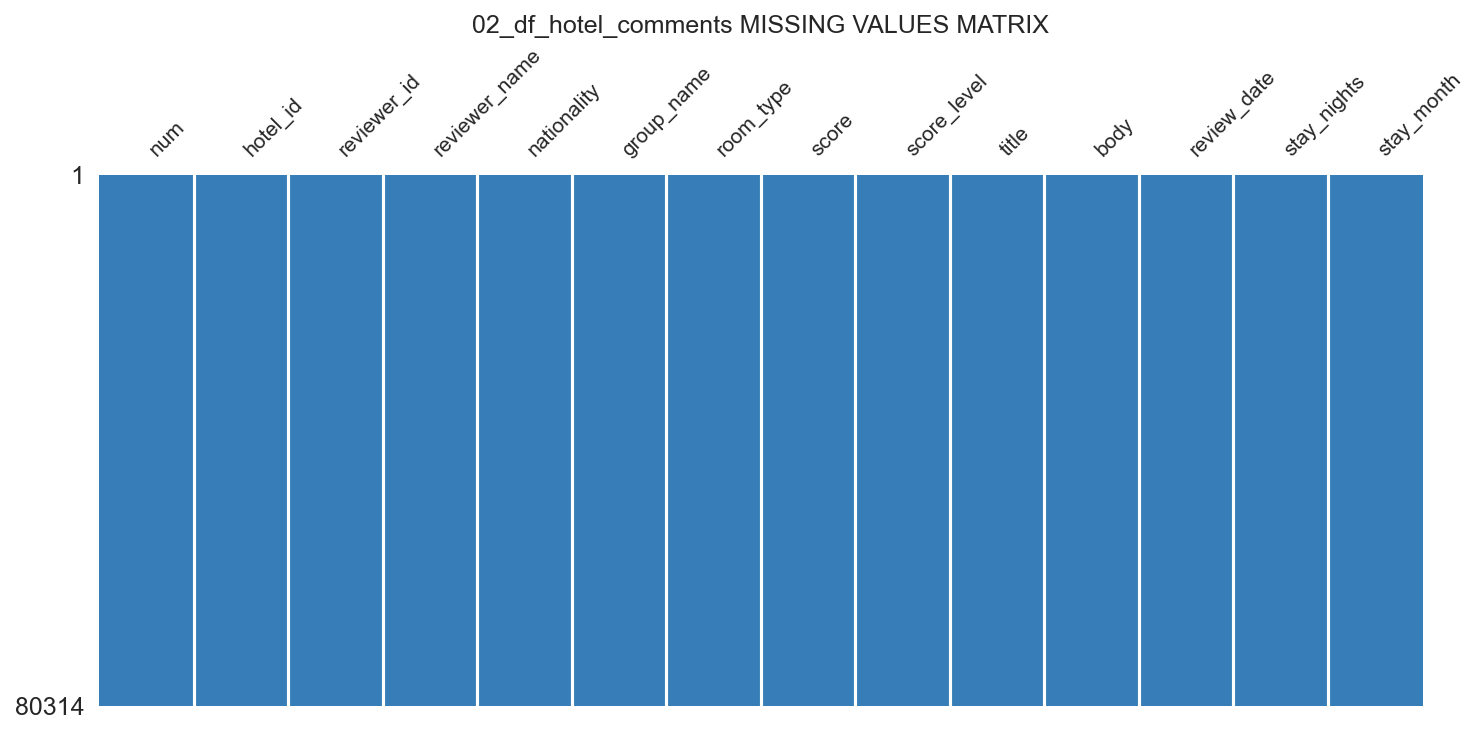

In [46]:
# check Null
fn_Null_NaN_count(df=df_hotel_comments)
fn_chart_missingvalue_matrix(df=df_hotel_comments, title="02_df_hotel_comments MISSING VALUES MATRIX", figsize=figsize, color=sns.color_palette("Set1")[1], dpi=dpi)

images/
------------------------------
04_df_hotel_comments_correlation_heatmap


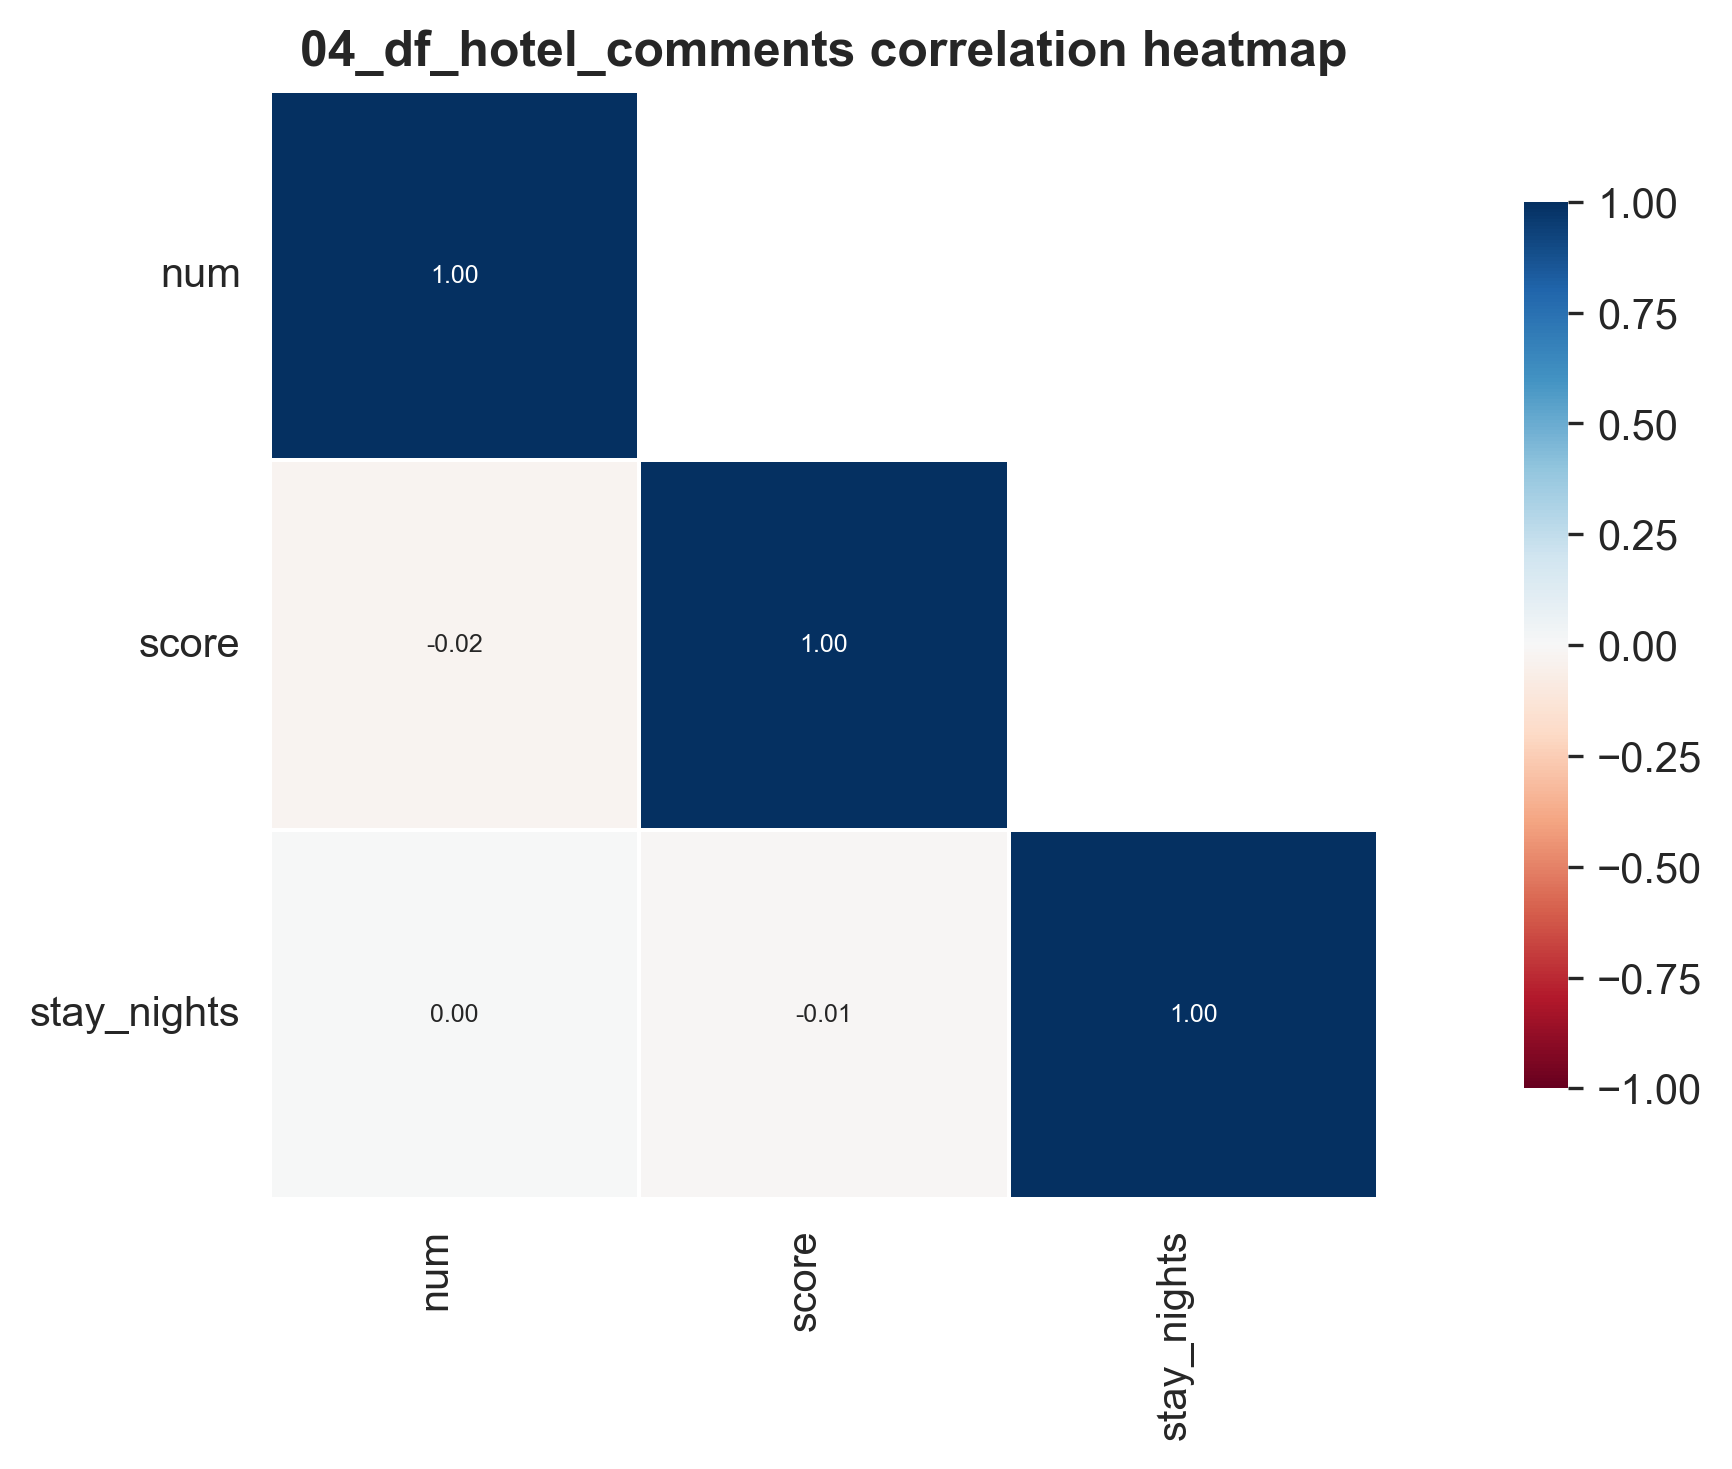

In [47]:
# corr heatmap
fn_chart_corr(df=df_hotel_comments, cols=list(df_hotel_comments.select_dtypes("number")), figsize=figsize, dpi=dpi, title='04_df_hotel_comments correlation heatmap')

### 4.9 Data final

In [48]:
# Data Final
df_info = df_hotel_info.copy()
fn_show(df=df_info, n=n_rows)
fn_save_csv(df=df_info, folder_path=path + out_path, file_name='01_df_info.csv', header=True, index=False, sep=",")

dataframe: 740 rows x 14 cols


,num,hotel_id,hotel_name,hotel_address,total_score,location,cleanliness,service,facilities,value_for_money,comfort_and_room_quality,comments_count,hotel_description,hotel_rank
0,1,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",8.8,9.4,8.9,8.9,8.7,8.7,8.3,1269,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,5.0
1,2,1_2,ALPHA BIRD NHA TRANG,"51/19/37 Tue Tinh St, Loc Tho Ward, Nha Trang,...",7.7,7.8,7.6,8.1,7.5,8.1,NaN,337,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...,4.0
2,3,1_3,Khách sạn Aaron (Aaron Hotel),"6Trần Quang Khải, Lộc Thọ, Nha Trang, Việt Nam...",8.5,8.9,8.7,8.8,8.1,8.5,NaN,300,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...,3.5


data_output/
------------------------------
01_df_info.csv


In [49]:
df_comments = df_hotel_comments.copy()
fn_show(df=df_comments, n=n_rows)
fn_save_csv(df=df_comments, folder_path=path + out_path, file_name='02_df_comments.csv', header=True, index=False, sep=",")

dataframe: 80,314 rows x 14 cols


,num,hotel_id,reviewer_id,reviewer_name,nationality,group_name,room_type,score,score_level,title,body,review_date,stay_nights,stay_month
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,10.0,Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,2023-07-30,3,2023-07-01
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,10.0,Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,2022-09-05,1,2022-09-01
2,3,1_1,1_1_3,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,9.2,Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",2024-06-25,1,2024-06-01


data_output/
------------------------------
02_df_comments.csv


## 5. Data Preprocessing


## 6. Modeling

| Hậu tố | Ý nghĩa                                |
|--------|----------------------------------------|
| _c1  | case 1: gensim + TF-IDF            |
| _c2  | case 2: cosine similarity          |
| _c3  | case 3: ALS model                  |
| _c4  | case 4: hotel Insight              |

In [50]:
# vietnamese stop words
for f in fn_file_listing(root_path=path + in_path + "files"):
    print(f"{f}")

emojicon.txt
english-vnmese.txt
teencode.txt
vietnamese-stopwords.txt
wrong-word.txt


In [51]:
# emoji
emoji = fn_read_dict(path=path + in_path + "files\\emojicon.txt")
# print sample
for i, (k, v) in zip(range(n_rows + 1), emoji.items()):
    print(f"{k}: {v}")

❤: yêu
👍: thích
😍: cười
😊: cười


In [52]:
# english - vietnamese
engvie = fn_read_dict(path=path + in_path + "files\\english-vnmese.txt")
# print sample
for i, (k, v) in zip(range(n_rows + 1), engvie.items()):
    print(f"{k}: {v}")

district: huyện
pebble: đá cuội
wedding: lễ cưới
comment: bình luận


In [53]:
# teen code
teencode = fn_read_dict(path=path + in_path + "files\\teencode.txt")
# print sample
for i, (k, v) in zip(range(n_rows + 1), teencode.items()):
    print(f"{k}: {v}")

ctrai: con trai
khôg: không
bme: bố mẹ
cta: chúng ta


In [54]:
# vietnamese stop words
stopword_vie = fn_read_txt(path=path + in_path + "files\\vietnamese-stopwords.txt")
# print sample
for i in stopword_vie[:n_rows]: print(i)

a_lô
a_ha
ai


In [55]:
# wrong words
wrongword = fn_read_txt(path=path + in_path + "files\\wrong-word.txt")
# print sample
for i in wrongword[:n_rows]: print(i)

aud
se
gd


### 6.1 Content-based Filtering: using gensim + TF-IDF

In [56]:
# from pyvi.ViTokenizer import tokenize

In [57]:
# tạo cột content
df_hotel_info['content'] = df_hotel_info['hotel_description']

# clean text
df_hotel_info['content'] = df_hotel_info['content'].apply(
    lambda x: fn_clean_word(
        x,
    remove_number=True,
    remove_punctuation=True,
    remove_vie_tone=False,
    lower=False,
    )
)

In [58]:
# tạo cột content_wt
df_hotel_info['content_wt'] = df_hotel_info['content'].apply(lambda x: tokenize(str(x)) if str(x).strip() != "" else np.nan)

In [59]:
# print sample
df_hotel_info[['hotel_description', 'content', 'content_wt']].head(3)

,hotel_description,content,content_wt
0,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,Khách sạn Mường Thanh Luxury Nha Trang Nơi lư...,Khách_sạn Mường_Thanh_Luxury Nha_Trang Nơi lưu...
1,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...,ALPHA BIRD NHA TRANG Khách sạn sao tại Nha T...,ALPHA BIRD NHA TRANG Khách_sạn sao tại Nha_Tra...
2,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...,Khách sạn Aaron Nơi nghỉ dưỡng tuyệt vời tại ...,Khách_sạn Aaron Nơi nghỉ_dưỡng tuyệt_vời tại N...


In [60]:
# content_gem
content_gem = [[text for text in str(x).split()] if pd.notnull(x) and str(x).strip() != "" else [] for x in df_hotel_info['content_wt']]

In [61]:
# content_gem[0]

In [62]:
# len(content_gem)

In [63]:
# df_hotel_info['hotel_description'][7:10] \
#     .apply(lambda x: x.replace('\n', ' ').strip())

In [64]:
content_gem_cleaned = fn_clean_tokens(
    tokens=content_gem,
    dict_list=[emoji, teencode, engvie],
    stopword=stopword_vie,
    wrongword=wrongword,
)

## print sample
# content_gem_cleaned[0]

In [65]:
# bag of words
dictionary = corpora.Dictionary(content_gem_cleaned)

# Save dictionary to file
dictionary.save(path + model_path + "02_dictionary.dict")

# token to id
# dictionary.token2id

# feature count
feature_cnt = len(dictionary.token2id)
print(f"Number of features (word) in dictionary: {feature_cnt:,}")

Number of features (word) in dictionary: 8,038


In [66]:
corpus = [dictionary.doc2bow(text) for text in content_gem_cleaned]

# print sample
# corpus[0]

In [67]:
# Use TF-IDF Model to process corpus, obtaining index
model_tfidf = models.TfidfModel(corpus)

# save model TF-IDF
fn_save_model_joblib(model=model_tfidf, folder_path = path + model_path, model_name="01_tfidf.pkl")

# tính toán sự tương tự trong ma trận thưa thớt
# Khởi tạo index_matrix
index_matrix = similarities.SparseMatrixSimilarity(model_tfidf[corpus], num_features=feature_cnt)

# save matrix
fn_gensim_save_sparsematrixsimilarity(index_matrix = index_matrix ,folder_path = path + model_path, file_name = "03_gesim_sparsematrixsimilarity.index")

models/
------------------------------
01_tfidf.pkl
models/
------------------------------
03_gesim_sparsematrixsimilarity.index


In [68]:
# ma tran: n x n
df_index_matrix = pd.DataFrame(index_matrix)

# save .csv
fn_save_csv(df=df_index_matrix, folder_path = path + out_path, file_name = "03_gensim_tfidf_df_index_matrix.csv", header=False, index=False)

#print sample
display(df_index_matrix)

data_output/
------------------------------
03_gensim_tfidf_df_index_matrix.csv


,0,1,2,3,4,5,6,7,8,9,...,730,731,732,733,734,735,736,737,738,739
0,1.000000,0.681456,0.646543,0.563579,0.636613,0.630467,0.553825,0.547194,0.514439,0.188161,...,0.123319,0.547445,0.155374,0.434045,0.135823,0.077029,0.031552,0.032043,0.143605,0.494054
1,0.681456,1.000000,0.684327,0.605185,0.649625,0.636761,0.577654,0.565772,0.539875,0.193522,...,0.123347,0.578068,0.136680,0.451920,0.135800,0.086964,0.035229,0.035791,0.150619,0.506531
2,0.646543,0.684327,1.000000,0.588175,0.665446,0.660218,0.556695,0.575464,0.542137,0.196406,...,0.122598,0.571092,0.153357,0.469890,0.149368,0.081234,0.032761,0.042231,0.161770,0.512980
3,0.563579,0.605185,0.588175,1.000000,0.589138,0.603632,0.462512,0.470389,0.476595,0.148199,...,0.098598,0.504321,0.133268,0.395854,0.121529,0.091011,0.029865,0.034360,0.124950,0.446021
4,0.636613,0.649625,0.665446,0.589138,1.000000,0.618220,0.523336,0.539441,0.527784,0.195524,...,0.124254,0.526392,0.152993,0.420616,0.143568,0.094934,0.036024,0.043991,0.176033,0.461372
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0.077029,0.086964,0.081234,0.091011,0.094934,0.073410,0.059543,0.075903,0.079342,0.163763,...,0.325863,0.075970,0.181410,0.068532,0.153075,1.000000,0.463895,0.081857,0.158032,0.087258
736,0.031552,0.035229,0.032761,0.029865,0.036024,0.027167,0.027692,0.026370,0.027561,0.099398,...,0.091818,0.033045,0.111292,0.039269,0.103399,0.463895,1.000000,0.070016,0.150439,0.029853
737,0.032043,0.035791,0.042231,0.034360,0.043991,0.031200,0.046578,0.029720,0.034247,0.122110,...,0.099227,0.036944,0.189360,0.040445,0.111751,0.081857,0.070016,1.000000,0.159795,0.033014
738,0.143605,0.150619,0.161770,0.124950,0.176033,0.126102,0.124458,0.126503,0.137666,0.344663,...,0.217121,0.124835,0.391838,0.118273,0.295345,0.158032,0.150439,0.159795,1.000000,0.111574


### 6.2 Content-based Filtering: using cosine_similarity

In [69]:
df_hotel_info[['hotel_description', 'content', 'content_wt']].head(n=n_rows)

,hotel_description,content,content_wt
0,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,Khách sạn Mường Thanh Luxury Nha Trang Nơi lư...,Khách_sạn Mường_Thanh_Luxury Nha_Trang Nơi lưu...
1,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...,ALPHA BIRD NHA TRANG Khách sạn sao tại Nha T...,ALPHA BIRD NHA TRANG Khách_sạn sao tại Nha_Tra...
2,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...,Khách sạn Aaron Nơi nghỉ dưỡng tuyệt vời tại ...,Khách_sạn Aaron Nơi nghỉ_dưỡng tuyệt_vời tại N...


In [70]:
# import pandas as pd
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

In [71]:
# Vector hóa nội dung
# from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer="word", stop_words=stopword_vie)
tfidf_matrix = vectorizer.fit_transform(df_hotel_info["content_wt"].fillna(""))

# Tính toán độ tương đồng
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# save matrix
fn_cosine_sim_save(cosine_sim=cosine_sim, folder_path = path + model_path, file_name = "04_cosine_sparsematrixsimilarity.npy")

# Ma trận cosine_sim
df_index_matrix_cosine = pd.DataFrame(cosine_sim)

# save file csv
fn_save_csv(df=df_index_matrix_cosine, folder_path = path + out_path, file_name = "06_cosine_tfidf_df_index_matrix.csv")

models/
------------------------------
04_cosine_sparsematrixsimilarity.npy
data_output/
------------------------------
06_cosine_tfidf_df_index_matrix.csv


In [72]:
df_index_matrix_cosine

,0,1,2,3,4,5,6,7,8,9,...,730,731,732,733,734,735,736,737,738,739
0,1.000000,0.845490,0.801272,0.755606,0.813190,0.771241,0.782170,0.761803,0.729698,0.405734,...,0.241805,0.733114,0.297380,0.698699,0.313839,0.190613,0.127286,0.110724,0.333489,0.711550
1,0.845490,1.000000,0.829694,0.786510,0.825951,0.790436,0.803819,0.772408,0.753574,0.412394,...,0.235734,0.765531,0.282699,0.709789,0.311417,0.195543,0.131782,0.120811,0.342748,0.728097
2,0.801272,0.829694,1.000000,0.778408,0.825836,0.810373,0.766820,0.767852,0.744093,0.388169,...,0.249888,0.761331,0.289569,0.703458,0.311815,0.189285,0.120100,0.134103,0.347575,0.715126
3,0.755606,0.786510,0.778408,1.000000,0.778807,0.787901,0.704491,0.704652,0.711486,0.352723,...,0.206545,0.724578,0.266477,0.654740,0.274155,0.197217,0.110428,0.128906,0.312345,0.689931
4,0.813190,0.825951,0.825836,0.778807,1.000000,0.779090,0.757837,0.751487,0.742649,0.396552,...,0.247996,0.729283,0.293070,0.680357,0.307482,0.210410,0.128194,0.137672,0.364859,0.692355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735,0.190613,0.195543,0.189285,0.197217,0.210410,0.165060,0.165265,0.181085,0.183600,0.338567,...,0.553647,0.156804,0.354091,0.199641,0.336765,1.000000,0.501194,0.199821,0.326707,0.203496
736,0.127286,0.131782,0.120100,0.110428,0.128194,0.106786,0.121892,0.104889,0.127957,0.242860,...,0.203342,0.095217,0.237717,0.138952,0.258148,0.501194,1.000000,0.160183,0.277726,0.116822
737,0.110724,0.120811,0.134103,0.128906,0.137672,0.130458,0.118882,0.098191,0.127056,0.282430,...,0.202098,0.122290,0.309148,0.118427,0.283154,0.199821,0.160183,1.000000,0.313787,0.124264
738,0.333489,0.342748,0.347575,0.312345,0.364859,0.298200,0.314031,0.309493,0.322091,0.589003,...,0.402787,0.284549,0.614477,0.318710,0.531003,0.326707,0.277726,0.313787,1.000000,0.297595


### 6.3 Collaborative filtering: using ALS (spark)

In [73]:
# import findspark

# findspark.init()

# from pyspark.sql import SparkSession
# from pyspark import SparkContext
# from pyspark.sql import functions as F

# from pyspark.ml.recommendation import ALS
# from pyspark.ml.evaluation import RegressionEvaluator
# # convert string to index
# from pyspark.ml.feature import StringIndexer
# from pyspark.ml import Pipeline

In [74]:
sc = SparkContext(master="local", appName="agoda_recommendation_ALS")
spark = SparkSession(sc)

In [75]:
fn_show(df=df_hotel_comments[df_hotel_comments["score"].notna()], n = n_rows)

dataframe: 80,314 rows x 14 cols


,num,hotel_id,reviewer_id,reviewer_name,nationality,group_name,room_type,score,score_level,title,body,review_date,stay_nights,stay_month
0,1,1_1,1_1_1,MARIKO,Nhật Bản,Cặp đôi,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,10.0,Trên cả tuyệt vời,Cao nhất‼︎”,Tôi đã ở cùng chủ nhân trong 4 đêm. Nhân viên ...,2023-07-30,3,2023-07-01
1,2,1_1,1_1_2,Hong,Việt Nam,Đi công tác,Phòng Deluxe 2 Giường đơn Nhìn ra Biển,10.0,Trên cả tuyệt vời,Tháng 8”,Lựa chọn Mường Thanh vì giá cả phù hợp. Đặt On...,2022-09-05,1,2022-09-01
2,3,1_1,1_1_3,Guai,Việt Nam,Cặp đôi,Deluxe Hướng biển giường đôi,9.2,Trên cả tuyệt vời,Du lịch tại Nha Trang”,"Lần này đến với Nha Trang, tôi book phòng tại ...",2024-06-25,1,2024-06-01


In [76]:
# data input ALS
# sử dụng "score" làm cột "rating"
df_hotel_comments_ALS = spark.createDataFrame(df_hotel_comments[df_hotel_comments["score"].notna()][["hotel_id", "reviewer_name", "score"]])

# show sample
print(f"Hotel comments original data: {df_hotel_comments.shape[0]:,} rows x {df_hotel_comments.shape[1]} cols")
print(f"ALS               input data: {df_hotel_comments_ALS.count():,} rows x {len(df_hotel_comments_ALS.columns)} cols\n")
fn_show_spark(df=df_hotel_comments_ALS, n=n_rows, printSchema=True, truncate=False)

Hotel comments original data: 80,314 rows x 14 cols
ALS               input data: 80,314 rows x 3 cols

dataframe: 80,314 rows x 3 cols

root
 |-- hotel_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- score: double (nullable = true)

+--------+-------------+-----+
|hotel_id|reviewer_name|score|
+--------+-------------+-----+
|1_1     |MARIKO       |10.0 |
|1_1     |Hong         |10.0 |
|1_1     |Guai         |9.2  |
+--------+-------------+-----+
only showing top 3 rows



In [77]:
# kiểm tra giá trị null
df_hotel_comments_ALS.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_hotel_comments_ALS.columns]).show()

+--------+-------------+-----+
|hotel_id|reviewer_name|score|
+--------+-------------+-----+
|       0|            0|    0|
+--------+-------------+-----+



In [78]:
# distinct reviewers and hotels
reviewer_cnt = df_hotel_comments_ALS.select("reviewer_name").distinct().count()
hotel_cnt = df_hotel_comments_ALS.select("hotel_id").distinct().count()
numerator = df_hotel_comments_ALS.count()

print(f"Total numerator (ratings): {numerator:,}")
print(f"Total users              : {reviewer_cnt:,}")
print(f"Total hotels             : {hotel_cnt:,}")

Total numerator (ratings): 80,314
Total users              : 8,191
Total hotels             : 473


In [79]:
# denominator
denominator = reviewer_cnt * hotel_cnt
print(f"Total denominator (ratings matrix): {denominator:,}")

# calculate sparsity
sparsity = 1 - (numerator * 1.0 / denominator)
print(f"Sparsity: {sparsity:,.2%}")

Total denominator (ratings matrix): 3,874,343
Sparsity: 97.93%


In [80]:
# string indexer
indexer = StringIndexer(inputCol="hotel_id", outputCol="hotel_id_idx")
indexer_model = indexer.fit(df_hotel_comments_ALS)
data_indexed = indexer_model.transform(df_hotel_comments_ALS)

indexer_1 = StringIndexer(inputCol="reviewer_name", outputCol="reviewer_name_idx")
indexer_1_model = indexer_1.fit(data_indexed)
data_indexed = indexer_1_model.transform(data_indexed)

fn_show_spark(df=data_indexed, n=n_rows, truncate=False)

dataframe: 80,314 rows x 5 cols

+--------+-------------+-----+------------+-----------------+
|hotel_id|reviewer_name|score|hotel_id_idx|reviewer_name_idx|
+--------+-------------+-----+------------+-----------------+
|1_1     |MARIKO       |10.0 |15.0        |1682.0           |
|1_1     |Hong         |10.0 |15.0        |34.0             |
|1_1     |Guai         |9.2  |15.0        |1929.0           |
+--------+-------------+-----+------------+-----------------+
only showing top 3 rows



In [81]:
# kiểm tra giá trị null
data_indexed.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in data_indexed.columns]).show()

+--------+-------------+-----+------------+-----------------+
|hotel_id|reviewer_name|score|hotel_id_idx|reviewer_name_idx|
+--------+-------------+-----+------------+-----------------+
|       0|            0|    0|           0|                0|
+--------+-------------+-----+------------+-----------------+



In [82]:
# train test split
df_ALS_train, df_ALS_test = data_indexed.randomSplit([0.8, 0.2], seed=random_state)

##### Tuning hyperparameter

In [83]:
# # Tuning hyperparameter

# from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# from pyspark.ml.evaluation import RegressionEvaluator

In [84]:
# # ALS model
# als = ALS(
#     userCol="reviewer_name_idx",
#     itemCol="hotel_id_idx",
#     ratingCol="score",
#     coldStartStrategy="drop",
#     nonnegative=True
# )

# # evaluator
# evaluator = RegressionEvaluator(metricName="rmse", labelCol="score", predictionCol="prediction")

# # grid search
# paramGrid = (
#     ParamGridBuilder()
#     .addGrid(als.rank, [10, 25, 50])
#     .addGrid(als.regParam, [0.01, 0.05, 0.1])
#     .addGrid(als.maxIter, [10, 20])
#     .build()
# )

# # cross validation
# cv = CrossValidator(
#     estimator=als,
#     estimatorParamMaps=paramGrid,
#     evaluator=evaluator,
#     numFolds=3,             # 3-fold CV
#     parallelism=4           # chạy song song
# )

# # fit model
# cvModel = cv.fit(df_ALS_train)

# # best model
# bestModel = cvModel.bestModel
# print("Best rank:", bestModel.rank)
# print("Best regParam:", bestModel._java_obj.parent().getRegParam())
# print("Best maxIter:", bestModel._java_obj.parent().getMaxIter())

In [85]:
# Best rank: 50
# Best regParam: 0.05
# Best maxIter: 20

In [86]:
# ALS model
als = ALS(
    maxIter=20,
    regParam=0.05,
    rank=50,
    userCol="reviewer_name_idx",
    itemCol="hotel_id_idx",
    ratingCol="score",
    coldStartStrategy="drop",
    nonnegative=True,
)
ALS_model = als.fit(df_ALS_train)

# save model
ALS_model.write().overwrite().save(os.path.join(path, model_path, "05_ALS_model"))

In [87]:
# predictions
ALS_predictions = ALS_model.transform(df_ALS_test)
ALS_predictions.select(["hotel_id_idx", "reviewer_name_idx", "score", "prediction"]).show(n=n_rows)

+------------+-----------------+-----+----------+
|hotel_id_idx|reviewer_name_idx|score|prediction|
+------------+-----------------+-----+----------+
|        27.0|           1580.0|  9.6|  9.577195|
|        63.0|            463.0| 10.0|   9.86054|
|         6.0|            496.0| 10.0|  9.949467|
+------------+-----------------+-----+----------+
only showing top 3 rows



In [88]:
# evaluate
rmse = RegressionEvaluator(metricName="rmse", labelCol="score", predictionCol="prediction").evaluate(ALS_predictions)
print(f"Root Mean Squared Error (RMSE) = {rmse:.2f}")

Root Mean Squared Error (RMSE) = 0.62


Nhận xét: RMSE

| Chỉ số | Giá trị | Ý nghĩa |
|-------|---------|---------|
| RMSE `sau tuning` | **0.62** | - Cải thiện đáng kể, mức khá mạnh cho collaborative filtering<br>- Model dự đoán khá gần với hành vi user|

### 6.4 Hotel Insight

In [89]:
# tách ra file mới

## 7. Predict

### Predict top N = 

In [90]:
top_N: int = 3 # top 3 khách sạn tương đồng nhất
info_cols_toshow = [
    "hotel_id",
    "hotel_name",
    "hotel_address",
    "total_score",
    "location",
    "cleanliness",
    "service",
    "facilities",
    "value_for_money",
    "comfort_and_room_quality",
    "comments_count",
    "hotel_description",
    "hotel_rank",
]

In [91]:
# Danh sách Khách sạn
hotel_lst = df_hotel_info[['hotel_id', 'hotel_name']].drop_duplicates()
hotel_lst

,hotel_id,hotel_name
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...
1,1_2,ALPHA BIRD NHA TRANG
2,1_3,Khách sạn Aaron (Aaron Hotel)
3,1_4,Panorama Star Beach Nha Trang
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...
...,...,...
735,16_5,Victor Condotel Cam Ranh
736,30_24,Victor Group - Sam Sam Cam Ranh Condotel
737,27_21,Victory's House Ngoc Hoa
738,8_21,Western Seaview (The Arena Cam Ranh)


### Chọn 'Khách sạn' trên index

In [92]:
# seed
np.random.seed(random_state)

# Giả sử chọn 1 khách sạn:
search_hotel_idx = np.random.randint(0, len(hotel_lst))
search_hotel_id = hotel_lst.iloc[search_hotel_idx]["hotel_id"]
search_hotel_name = hotel_lst.iloc[search_hotel_idx]["hotel_name"]

print(f"hotel_idx  : {search_hotel_idx}")
print(f"hotel_id   : {search_hotel_id}")
print(f"hotel_name : {search_hotel_name}")

hotel_idx  : 102
hotel_id   : 5_6
hotel_name : Khách sạn và Spa Florida Nha Trang (Florida Nha Trang Hotel And Spa)


### Chọn 'Khách sạn' dựa trên từ khóa tìm kiếm

In [93]:
# Giả sử nhập tìm kiếm như sau
search_input = "Khách sạn mới, phòng ngủ rộng, gần biển và phù hợp với nhu cầu du lịch cho gia đình"

### 7.1 Content-based Filtering: using gensim + TF-IDF

#### 7.1.1 Search bằng index

In [94]:
# top N khách sạn tương đồng với Khách sạn đang chọn
top_indices_c1 = df_index_matrix.loc[search_hotel_idx].drop(search_hotel_idx, errors='ignore').nlargest(top_N).index.tolist()
print(f"top indices idx: {top_indices_c1}")

# predict
df_predict_c1 = df_hotel_info.loc[df_hotel_info.index[top_indices_c1], info_cols_toshow]
fn_show(df=df_predict_c1, n=None)

# save csv
fn_save_csv(df=df_predict_c1, folder_path = path + out_path, file_name = '04_gensim_tfidf_predict_idx.csv', header=True, index=True)

top indices idx: [29, 623, 245]
dataframe: 3 rows x 13 cols


,hotel_id,hotel_name,hotel_address,total_score,location,cleanliness,service,facilities,value_for_money,comfort_and_room_quality,comments_count,hotel_description,hotel_rank
29,1_30,Areca Hotel Nha Trang,"46A đường Ho&#224;ng Văn Thụ, phường Vạn Thạnh...",8.9,9.0,9.2,9.1,8.9,9.2,NaN,160,Khám phá Areca Hotel Nha Trang - Khách sạn 4.0...,4.0
623,4_16,Khách sạn Dqua (DQua Hotel),"29 Phan Chu Trinh Street, Xương Huân, Nha Tran...",8.6,8.5,9.0,9.1,8.6,9.1,NaN,149,Khách sạn Dqua - Nơi lưu trú lý tưởng tại Nha ...,5.0
245,23_25,Khách sạn Quinter Central Nha Trang (Quinter C...,"86/4 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam, 6...",8.9,8.6,9.3,9.1,9.0,9.0,NaN,143,Khách sạn Quinter Central Nha Trang: Nơi lưu t...,NaN


data_output/
------------------------------
04_gensim_tfidf_predict_idx.csv


In [95]:
# # sử dụng bằng file csv đã lưu trước đó
# df_index_matrix_csv = fn_read_csv(folder_path = path + out_path, file_name = "03_gensim_tfidf_df_index_matrix.csv", header=False)

# top_indices_c1_csv = df_index_matrix_csv.loc[search_hotel_idx].drop(search_hotel_idx, errors='ignore').nlargest(top_N).index.tolist()
# print(f"top indices idx: {top_indices_c1_csv}")

# # predict
# df_predict_c1_csv = df_hotel_info.loc[df_hotel_info.index[top_indices_c1_csv], info_cols_toshow]
# fn_show(df=df_predict_c1_csv, n=None)

# # save csv
# fn_save_csv(df=df_predict_c1_csv, folder_path = path + out_path, file_name = '04_gensim_tfidf_predict_idx.csv', header=True, index=True)

#### 7.1.2 Search bằng từ khóa

In [96]:
# từ khóa
print(f"search: '{search_input}'")

search: 'Khách sạn mới, phòng ngủ rộng, gần biển và phù hợp với nhu cầu du lịch cho gia đình'


In [97]:
search_input_clean = fn_clean_word(search_input, remove_number=True, remove_punctuation=True, remove_vie_tone=False, lower=False)

# xử lý token của search_input
search_input_tokens = fn_clean_tokens(
    tokens=tokenize(search_input).split(),
    dict_list=[emoji, teencode, engvie],
    stopword=stopword_vie,
    wrongword=wrongword,
)

# load dictionary from file
loaded_dictionary = corpora.Dictionary.load(path + model_path +"02_dictionary.dict")

# load model tf-idf
loaded_model_tfidf = fn_load_model_joblib(folder_path = path + model_path, model_name = "01_tfidf.pkl")

# load index matrix
loaded_index_matrix = fn_gensim_load_sparsematrixsimilarity(folder_path = path + model_path, file_name = "03_gesim_sparsematrixsimilarity.index")

# sim
sim = loaded_index_matrix[loaded_model_tfidf[loaded_dictionary.doc2bow(search_input_tokens)]]

# top N khách sạn tương đồng với từ khóa
recommend = pd.DataFrame({"id": range(len(sim)), "sim": sim}).nlargest(n=top_N, columns="sim")
top_indices_c1_search = recommend['id'].to_list()
print(f"top indices idx: {top_indices_c1_search}")

# predict
df_predict_c1_search = df_hotel_info.loc[df_hotel_info.index[top_indices_c1], info_cols_toshow]
fn_show(df=df_predict_c1_search, n=None)

# save csv
fn_save_csv(df=df_predict_c1_search, folder_path = path + out_path, file_name = '05_gensim_tfidf_predict_search.csv', header=True, index=True)

top indices idx: [326, 718, 552]
dataframe: 3 rows x 13 cols


,hotel_id,hotel_name,hotel_address,total_score,location,cleanliness,service,facilities,value_for_money,comfort_and_room_quality,comments_count,hotel_description,hotel_rank
29,1_30,Areca Hotel Nha Trang,"46A đường Ho&#224;ng Văn Thụ, phường Vạn Thạnh...",8.9,9.0,9.2,9.1,8.9,9.2,NaN,160,Khám phá Areca Hotel Nha Trang - Khách sạn 4.0...,4.0
623,4_16,Khách sạn Dqua (DQua Hotel),"29 Phan Chu Trinh Street, Xương Huân, Nha Tran...",8.6,8.5,9.0,9.1,8.6,9.1,NaN,149,Khách sạn Dqua - Nơi lưu trú lý tưởng tại Nha ...,5.0
245,23_25,Khách sạn Quinter Central Nha Trang (Quinter C...,"86/4 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam, 6...",8.9,8.6,9.3,9.1,9.0,9.0,NaN,143,Khách sạn Quinter Central Nha Trang: Nơi lưu t...,NaN


data_output/
------------------------------
05_gensim_tfidf_predict_search.csv


### 7.2 Content-based Filtering: using cosine_similarity

#### 7.2.1 Search bằng index

In [98]:
# top N khách sạn tương đồng với Khách sạn đang chọn
top_indices_c2 = df_index_matrix_cosine.loc[search_hotel_idx].drop(search_hotel_idx, errors='ignore').nlargest(top_N).index.tolist()
print(f"top indices idx: {top_indices_c2}")

# predict
df_predict_c2 = df_hotel_info.loc[df_hotel_info.index[top_indices_c2], info_cols_toshow]
fn_show(df=df_predict_c2, n=None)

# save csv
fn_save_csv(df=df_predict_c2, folder_path = path + out_path, file_name = '07_cosine_tfidf_predict_idx.csv', header=True, index=True)

top indices idx: [29, 0, 49]
dataframe: 3 rows x 13 cols


,hotel_id,hotel_name,hotel_address,total_score,location,cleanliness,service,facilities,value_for_money,comfort_and_room_quality,comments_count,hotel_description,hotel_rank
29,1_30,Areca Hotel Nha Trang,"46A đường Ho&#224;ng Văn Thụ, phường Vạn Thạnh...",8.9,9.0,9.2,9.1,8.9,9.2,NaN,160,Khám phá Areca Hotel Nha Trang - Khách sạn 4.0...,4.0
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,"60 Trần Phú, Lộc Thọ, Nha Trang, Việt Nam",8.8,9.4,8.9,8.9,8.7,8.7,8.3,1269,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,5.0
49,2_20,Khách sạn V Nha Trang (V Hotel Nha Trang),"8 Hung Vuong, Lộc Thọ, Nha Trang, Việt Nam, 57000",8.6,9.0,8.8,8.7,8.3,8.7,NaN,475,Khách sạn V Nha Trang - Nơi lưu trú lý tưởng t...,4.0


data_output/
------------------------------
07_cosine_tfidf_predict_idx.csv


#### 7.2.2 Search bằng từ khóa

In [99]:
# từ khóa
print(f"search: '{search_input}'")

search: 'Khách sạn mới, phòng ngủ rộng, gần biển và phù hợp với nhu cầu du lịch cho gia đình'


In [100]:
# Khởi tạo lại vectorizer và fit trên toàn bộ dữ liệu để đảm bảo tính nhất quán khi transform search_input
vectorizer = TfidfVectorizer(analyzer="word", stop_words=stopword_vie)
tfidf_matrix = vectorizer.fit_transform(df_hotel_info["content_wt"].fillna(""))

# Vector hóa search_input
search_vec = vectorizer.transform([search_input])

# Tính toán độ tương đồng giữa search_input và toàn bộ khách sạn (dùng lại tfidf_matrix đã fit)
cosine_sim_search = cosine_similarity(search_vec, tfidf_matrix).flatten()


# top N khách sạn tương đồng với từ khóa
recommend_cosine = pd.DataFrame({"id": range(len(cosine_sim_search)), "sim": cosine_sim_search}).nlargest(n=top_N, columns="sim")

top_indices_c2_search = recommend_cosine['id'].to_list()
print(f"top indices idx: {top_indices_c2_search}")

# predict
df_predict_c2_search = df_hotel_info.loc[df_hotel_info.index[top_indices_c2_search], info_cols_toshow]
fn_show(df=df_predict_c2_search, n=None)

# save csv
fn_save_csv(df=df_predict_c2_search, folder_path=path + out_path, file_name='08_cosine_tfidf_predict_search.csv', header=True, index=True)

top indices idx: [330, 641, 683]
dataframe: 3 rows x 13 cols


,hotel_id,hotel_name,hotel_address,total_score,location,cleanliness,service,facilities,value_for_money,comfort_and_room_quality,comments_count,hotel_description,hotel_rank
330,38_10,"Căn hộ 70 m² 2 phòng ngủ, 2 phòng tắm riêng ở ...","Xương Huân, Nha Trang, Việt Nam",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,CĂN HỘ ĐA TIỆN ÍCH PHÙ HỢP CHO GIA ĐÌNH & NHÓM...,NaN
641,17_14,Muong Thanh Vien Trieu Apartment Review Nha Trang,"3 Phạm Văn Đồng, Mường Thanh Viễn Triều, Vĩnh ...",5.2,2.0,2.0,NaN,NaN,2.0,NaN,0,Mường Thanh Viễn Triều là khu tổ hợp gồm 4 tòa...,NaN
683,11_3,"Nhà riêng 400 m² 4 phòng ngủ, 5 phòng tắm riên...","Vạn Ninh, Nha Trang, Việt Nam",9.7,8.7,10.0,NaN,NaN,10.0,NaN,0,- Với không gian sân vườn rộng có chổ đậu xe ô...,3.0


data_output/
------------------------------
08_cosine_tfidf_predict_search.csv


### 7.3 Collaborative filtering: using ALS (spark)

##### Providing Recommendations: for all users

In [101]:
user_recs = ALS_model.recommendForAllUsers(numItems=top_N)
user_recs.show(n=n_rows, truncate=False)

+-----------------+------------------------------------------------------+
|reviewer_name_idx|recommendations                                       |
+-----------------+------------------------------------------------------+
|0                |[{427, 11.285076}, {435, 11.215444}, {433, 11.215444}]|
|1                |[{427, 11.290313}, {335, 11.142152}, {323, 11.12816}] |
|2                |[{427, 11.364938}, {323, 10.927577}, {335, 10.916201}]|
+-----------------+------------------------------------------------------+
only showing top 3 rows



In [102]:
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, StructType, StructField, FloatType, StringType

def replace_hotel_idx_with_id(recs):
    return [
        {"hotel_id": hotel_idx_to_id.get(rec["hotel_id_idx"], None), "rating": rec["rating"]}
        for rec in recs
    ]


# Lấy danh sách người dùng và khách sạn với index tương ứng
reviewer_agoda_lst = data_indexed.select("reviewer_name", "reviewer_name_idx").distinct()
hotels_agoda_lst = data_indexed.select("hotel_id", "hotel_id_idx").distinct()

# Join bảng gợi ý với bảng người dùng để lấy thông tin reviewer_name
user_recs_joined = user_recs.join(reviewer_agoda_lst, on="reviewer_name_idx", how="left")

# Tạo dictionary ánh xạ từ hotel_id_idx sang hotel_id
hotel_idx_to_id = {row["hotel_id_idx"]: row["hotel_id"] for row in hotels_agoda_lst.collect()}

# Định nghĩa schema cho cột recommendations mới
schema_agoda = ArrayType(
    StructType(
        [
            StructField("hotel_id", StringType(), True),
            StructField("rating", FloatType(), True),
        ]
    )
)

replace_udf_agoda = F.udf(replace_hotel_idx_with_id, schema_agoda)

# Áp dụng UDF để thay thế hotel_id_idx bằng hotel_id thực tế
new_user_recs_joined = user_recs_joined.withColumn("recommendations", replace_udf_agoda(F.col("recommendations")))

In [103]:
print(f"new_user_recs: {new_user_recs_joined.count():,} rows x {len(new_user_recs_joined.columns)} cols\n")
new_user_recs_joined.printSchema()
new_user_recs_joined.select("reviewer_name", "recommendations").show(3, truncate=False)

new_user_recs: 7,645 rows x 3 cols

root
 |-- reviewer_name_idx: integer (nullable = false)
 |-- recommendations: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- hotel_id: string (nullable = true)
 |    |    |-- rating: float (nullable = true)
 |-- reviewer_name: string (nullable = true)

+-------------+------------------------------------------------------------+
|reviewer_name|recommendations                                             |
+-------------+------------------------------------------------------------+
|Nguyễn       |[{18_30, 11.285076}, {26_11, 11.215444}, {25_16, 11.215444}]|
|Nguyen       |[{18_30, 11.290313}, {7_9, 11.142152}, {12_13, 11.12816}]   |
|Thanh        |[{39_17, 10.741875}, {18_30, 10.707574}, {16_14, 10.251324}]|
+-------------+------------------------------------------------------------+
only showing top 3 rows



In [104]:
def flatten_recommendations(new_user_recs_joined, hotels_agoda_lst):
    from pyspark.sql import Row
    from pyspark.sql.functions import udf, col
    from pyspark.sql.types import IntegerType

    # Build mapping from hotel_id to hotel_id_idx
    hotel_id_to_idx = {row["hotel_id"]: row["hotel_id_idx"] for row in hotels_agoda_lst.collect()}

    def explode_recommendations(row):
        results = []
        if row["recommendations"]:
            for rec in row["recommendations"][:3]:  # only top 3
                results.append(
                    Row(
                        reviewer_name=row["reviewer_name"],
                        reviewer_name_idx=row["reviewer_name_idx"],
                        hotel_id=rec["hotel_id"],
                        hotel_idx=hotel_id_to_idx.get(rec["hotel_id"], None),
                        score=rec["rating"]
                    )
                )
        return results

    flat_rows = (
        new_user_recs_joined
        .select("reviewer_name", "reviewer_name_idx", "recommendations")
        .rdd.flatMap(explode_recommendations)
    )
    flat_df = new_user_recs_joined.sql_ctx.createDataFrame(flat_rows)
    flat_df = flat_df.select("reviewer_name", "reviewer_name_idx", "hotel_id", "hotel_idx", "score")
    return flat_df

# flatted
new_user_recs_joined_flatted = flatten_recommendations(new_user_recs_joined, hotels_agoda_lst)
new_user_recs_joined_flatted.show(n=n_rows, truncate=False)

+-------------+-----------------+--------+---------+------------------+
|reviewer_name|reviewer_name_idx|hotel_id|hotel_idx|score             |
+-------------+-----------------+--------+---------+------------------+
|angela       |299              |18_30   |427.0    |11.00042724609375 |
|angela       |299              |39_17   |293.0    |10.853143692016602|
|angela       |299              |7_9     |335.0    |10.641121864318848|
+-------------+-----------------+--------+---------+------------------+
only showing top 3 rows



In [105]:
# save csv
new_user_recs_joined_flatted_pd = new_user_recs_joined_flatted.toPandas()
fn_save_csv(df=new_user_recs_joined_flatted_pd, folder_path=path + out_path, file_name="09_ALS_recommendation_for_all_user.csv", header=True, index=True)

data_output/
------------------------------
09_ALS_recommendation_for_all_user.csv


### 7.4 Hotel Insight

In [106]:
# tách ra file mới